In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from astropy.io import ascii
import emcee as emcee
from astropy import constants, units
import os
import corner
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde
from astropy.visualization import (PercentileInterval, ImageNormalize, AsinhStretch,LinearStretch)
from astropy.io import fits
import seaborn as sns


Q 0 0.01562736898680742 7.683080734314e-05
Q 1 0.01562736898680742 7.683080734314e-05
Q 1f 0.01562736898680742 7.683080734314e-05
Q 2 0.01562736898680742 7.683080734314e-05
Q 3 0.01562736898680742 7.683080734314e-05
A 0 0.020836649652913614 9.98238930479e-05
A 1 0.020836649652913614 9.98238930479e-05
A 1f 0.020836649652913614 9.98238930479e-05
A 2 0.020836649652913614 9.98238930479e-05
A 3 0.020836649652913614 9.98238930479e-05
K 0 0.03125544736273178 0.0001423247444474
K 1 0.03125544736273178 0.0001423247444474
K 1f 0.03125544736273178 0.0001423247444474
K 2 0.03125544736273178 0.0001423247444474
K 3 0.03125544736273178 0.0001423247444474
U 0 0.04558698901279635 0.0002048634978789
U 1 0.04558698901279635 0.0002048634978789
U 1f 0.04558698901279635 0.0002048634978789
U 2 0.04558698901279635 0.0002048634978789
U 3 0.04558698901279635 0.0002048634978789
X 0 0.06876572886701464 0.0003102172775209
X 1 0.06876572886701464 0.0003102172775209
X 1f 0.06876572886701464 0.0003102172775209
X 2 0.

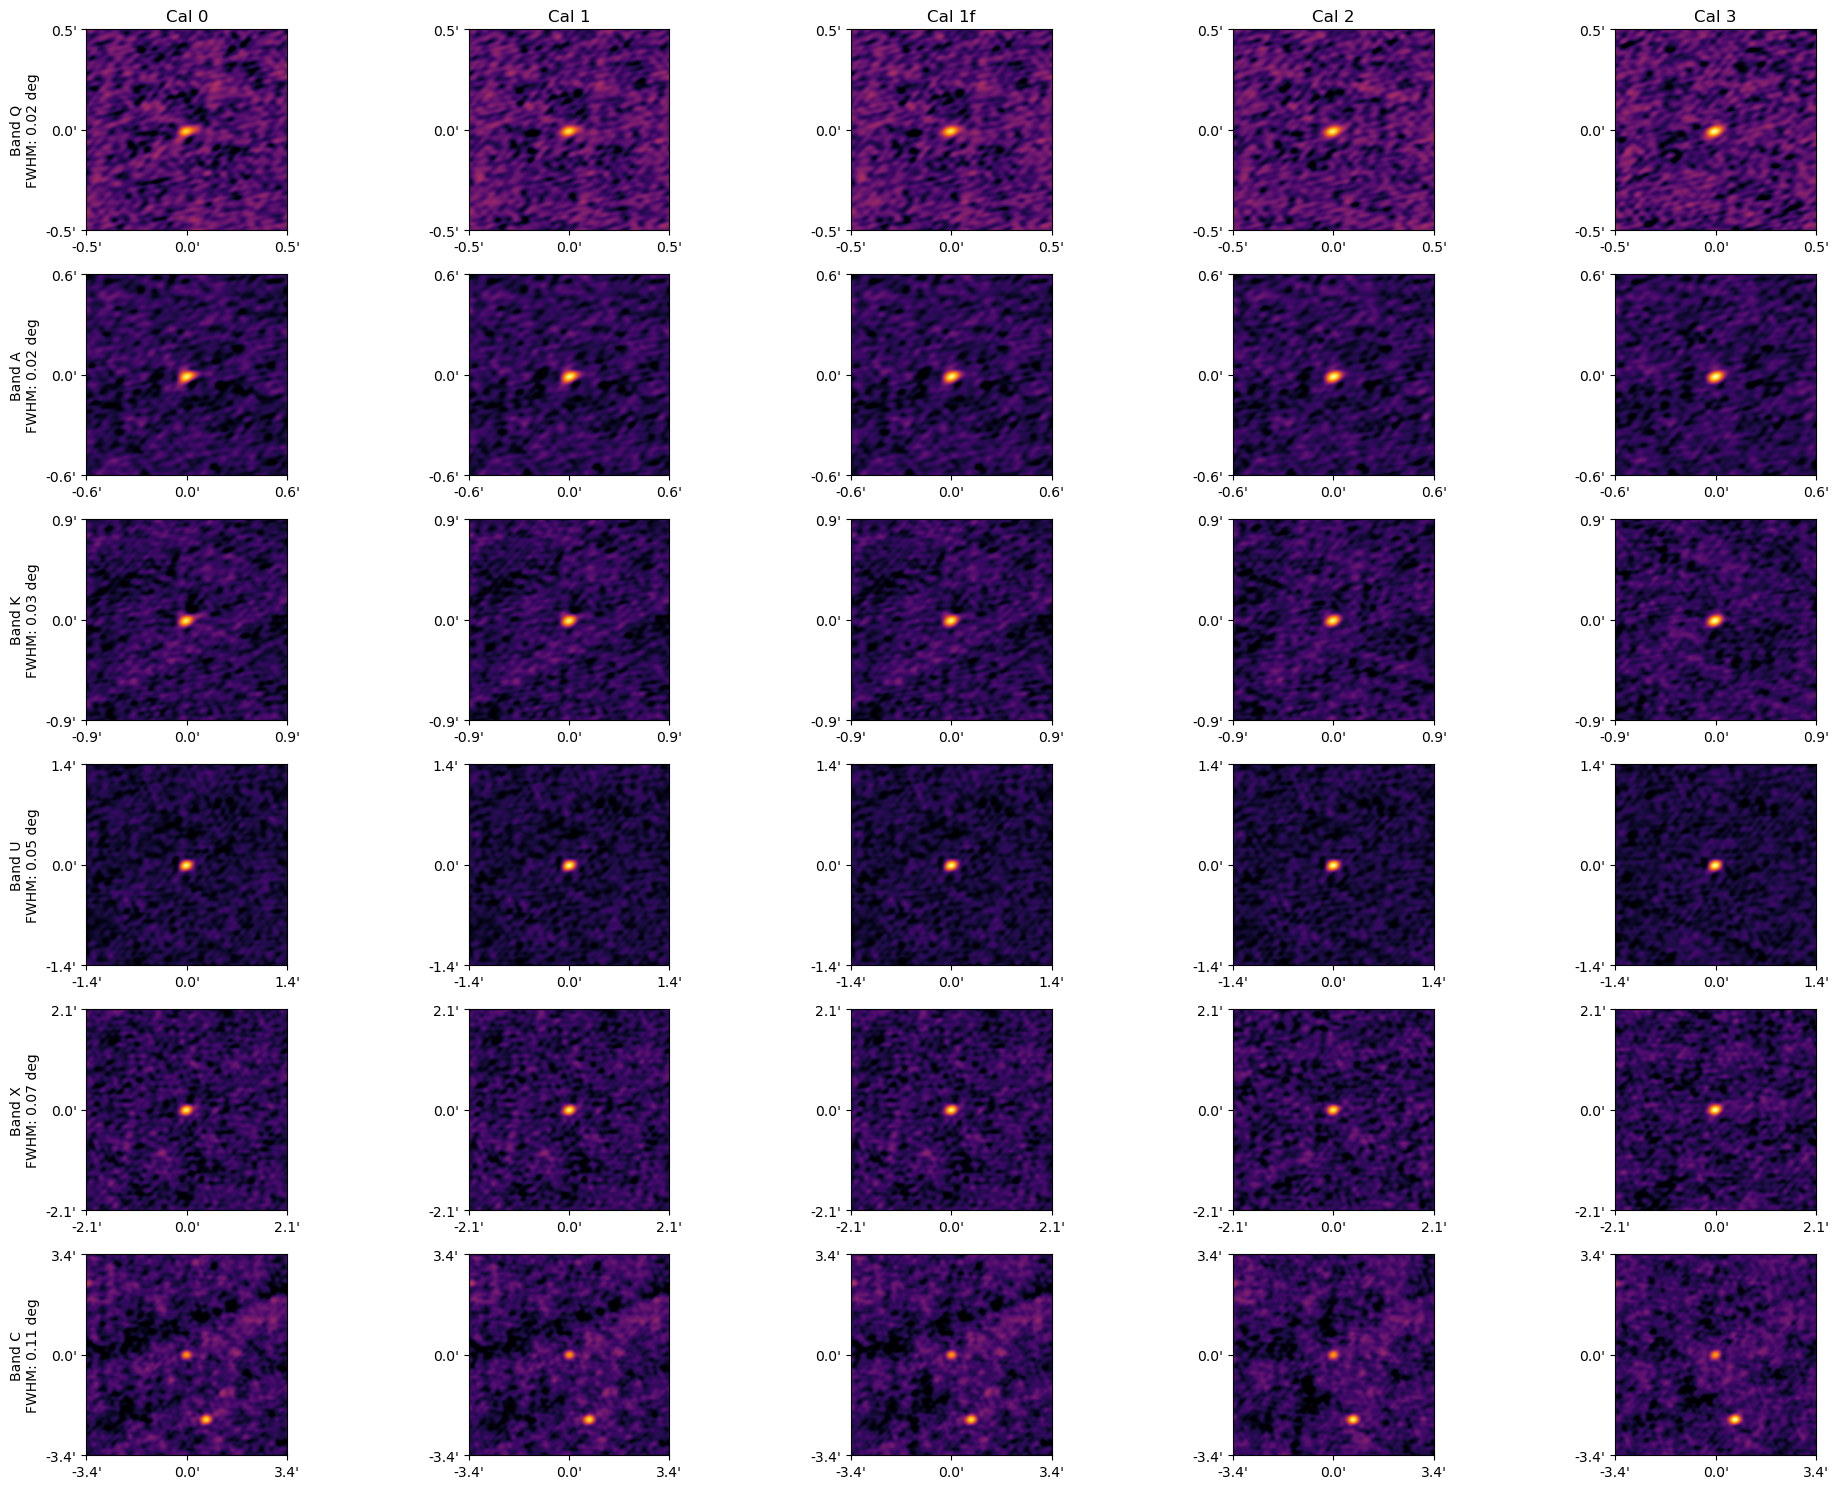

In [24]:

# Constants
D = 25  # Antenna diameter in meters
c = 3e8  # Speed of light in m/s

# Function to calculate FWHM (lambda/D)
def calculate_fwhm(fits_filename):
    with fits.open(fits_filename) as hdul:
        header = hdul[0].header

        # Extract the frequency (assuming it's in Hz in CRVAL3 or a similar keyword)
        frequency_hz = header.get('CRVAL3')  # Adjust the keyword if necessary

    wavelength = c / frequency_hz  # Wavelength in meters
    fwhm = wavelength / D  # FWHM in radians
    fwhm_deg = np.degrees(fwhm)  # Convert to degrees
    return fwhm_deg

# Frequency mapping for VLA bands (center frequencies in Hz)
band_frequencies = {
    "Q": 45e9,
    "A": 43e9,
    "K": 24e9,
    "U": 15e9,
    "X": 8.4e9,
    "C": 5e9,
}

# Files template: MWC480_{band}.contp{calibration}.image.tt0.fits
bands = ["Q", "A", "K", "U", "X", "C"]
calibrations = ["0", "1", "1f", "2", "3"]

# Function to load the image data and header
def load_fits_image(filename):
    with fits.open(filename) as hdul:
        image_data = hdul[0].data.squeeze()  # Assuming the image is in the primary HDU
        header = hdul[0].header
    return image_data, header

# Plot the images
fig, axes = plt.subplots(nrows=len(bands), ncols=len(calibrations), figsize=(20, 15))

every_band_data = []
for i, band in enumerate(bands):
    filename = ''

    # For color normalization, compute the min/max for each row (band)
    band_images = []
    for j, cal in enumerate(calibrations):
        if band == 'C' or band == 'X':
            cal = cal + '-peeled'

        filename = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'
        image_data, header = load_fits_image(filename)
        band_images.append(image_data)

    # Calculate normalization based on all images in this band
    all_band_data = np.concatenate([img.flatten() for img in band_images])
    vmin, vmax = np.percentile(all_band_data, [1, 100])  # Percentile for color stretch
    fwhm_deg = calculate_fwhm(filename)
    every_band_data.append([img.flatten() for img in band_images])
    # Plot each image
    for j, cal in enumerate(calibrations):
        ax = axes[i, j]
        img = band_images[j]

        # Normalize and stretch the color scale
        norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
        ax.imshow(img, cmap='inferno', origin='lower',norm=norm)


        pixel_scale_deg = np.abs(header['CDELT1'])
        pixel_scale = pixel_scale_deg

        fwhm_pixels = fwhm_deg / pixel_scale
        print(band, cal,fwhm_deg,pixel_scale)

        # Center the FWHM box on the image
        img_center_x = img.shape[1] // 2
        img_center_y = img.shape[0] // 2
        half_fwhm_pixels = fwhm_pixels / 2

        delta_extent_arcsec = np.array([-half_fwhm_pixels, 0, half_fwhm_pixels]) * pixel_scale*60 


        # Set the plot limits based on FWHM in pixels, centered on the image
        ax.set_xlim(img_center_x - half_fwhm_pixels, img_center_x + half_fwhm_pixels)
        ax.set_ylim(img_center_y - half_fwhm_pixels, img_center_y + half_fwhm_pixels)

        ax.set_xticks([img_center_x - half_fwhm_pixels, img_center_x, img_center_x + half_fwhm_pixels])
        ax.set_xticklabels([f"{x:.1f}'" for x in delta_extent_arcsec])  # Δ" from center
        ax.set_yticks([img_center_y - half_fwhm_pixels, img_center_y, img_center_y + half_fwhm_pixels])
        ax.set_yticklabels([f"{y:.1f}'" for y in delta_extent_arcsec])  # Δ" from center

        # Set title and labels for the first row/column
        if i == 0:
            ax.set_title(f'Cal {cal}')
        if j == 0:
            ax.set_ylabel(f'Band {band}\nFWHM: {fwhm_deg:.2f} deg')

    
plt.tight_layout()
plt.show()


In [33]:
band_cals[cal_num].dtype.byteorder

'>'

[0.0034656252, 0.001651272, 0.0008560724, 0.00044998172, 0.00031715972, 0.0002803063]


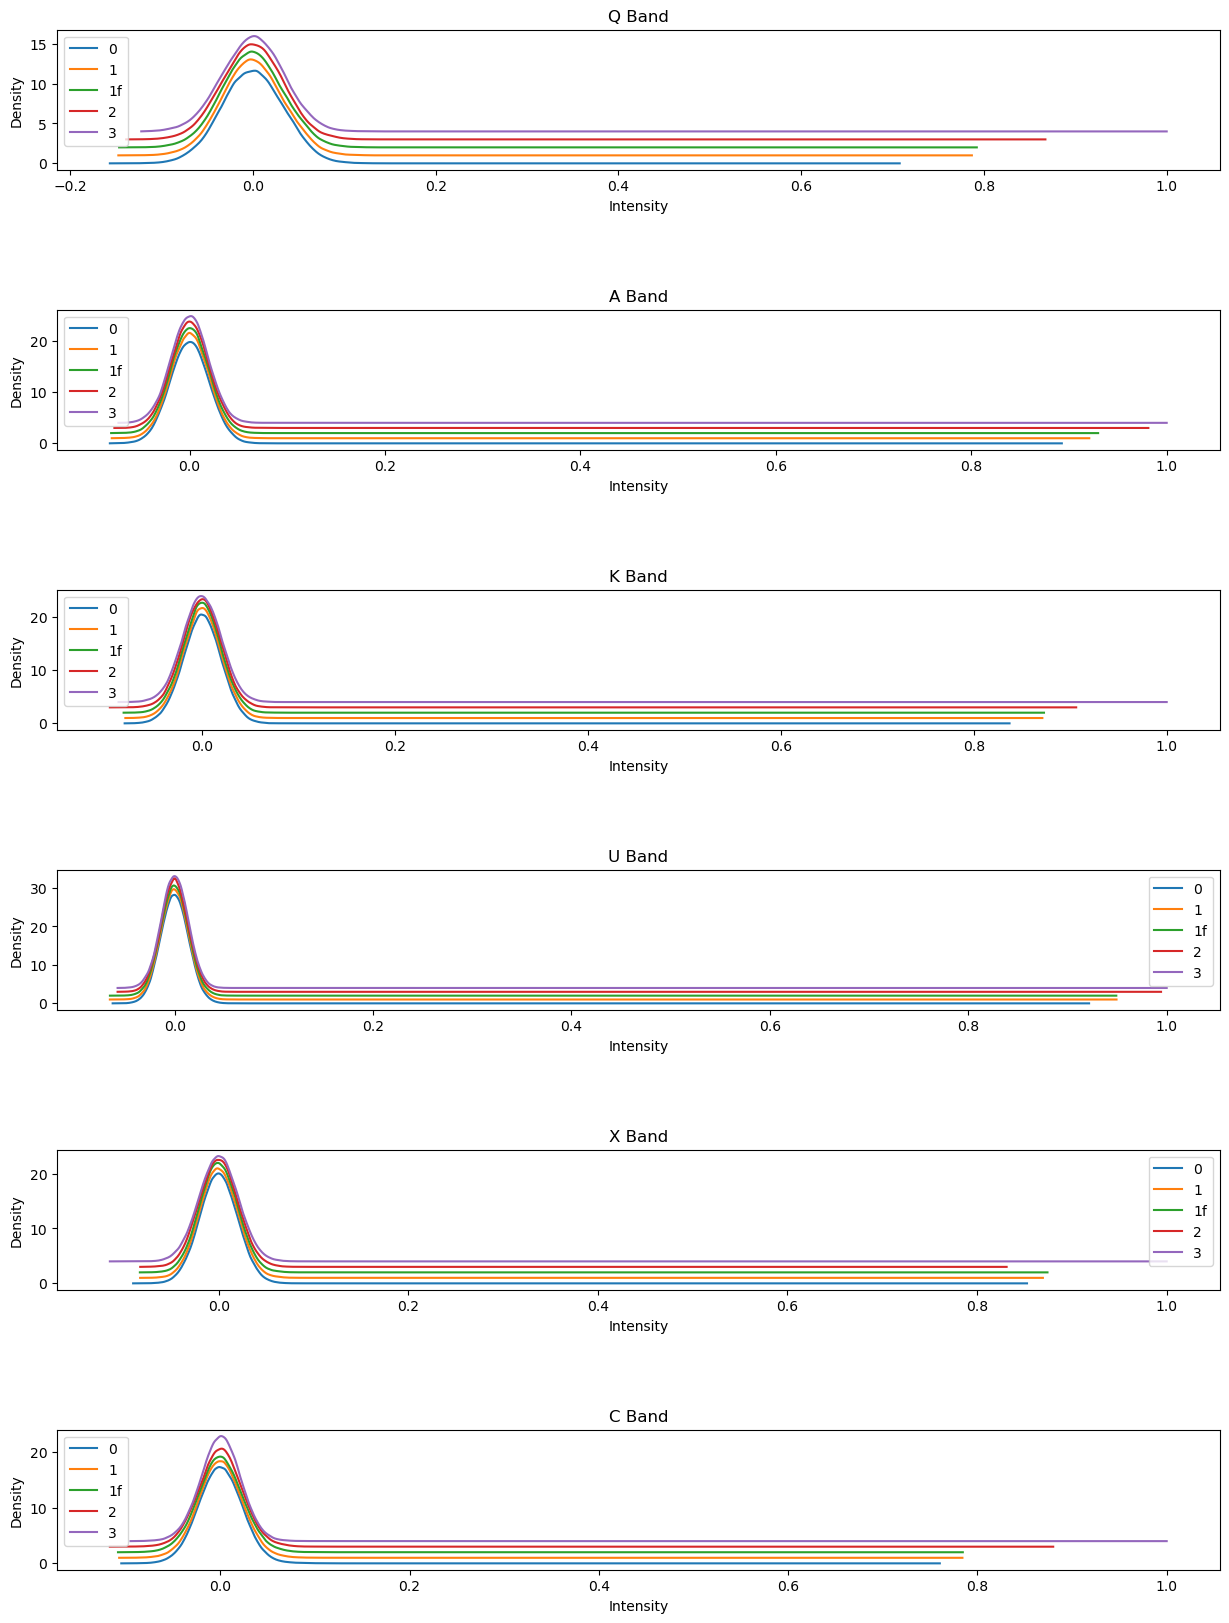

In [48]:
fig, axs = plt.subplots(6,1,figsize=(15,20))
bands = ["Q", "A", "K", "U", "X", "C"]
calibrations = ["0", "1", "1f", "2", "3"]


absolute_maxes = [max([max(sublist) for sublist in x]) for x in every_band_data]
print(absolute_maxes)
for band_num in range(6):
    band_max = absolute_maxes[band_num]
    band_cals = every_band_data[band_num]
    for cal_num in range(5):
        data = band_cals[cal_num]
        if data.dtype.byteorder == '>':  # Big-endian
            data = data.byteswap().newbyteorder()

        data /= band_max
        kde = gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 1000)  # Generate x values
        y_vals = kde(x_vals)
        axs[band_num].plot(x_vals, y_vals + cal_num, label=calibrations[cal_num])


    axs[band_num].set_title(bands[band_num] + " Band")
    axs[band_num].set_xlabel("Intensity")
    axs[band_num].set_ylabel("Density")
    axs[band_num].legend()
    # axs[band_num].set_yscale('log')


plt.subplots_adjust(hspace=1)


In [15]:
fwhm_pixels

263.8509184408761

In [13]:
0.08185111359011761 / 0.0003102172775209

263.8509184408761

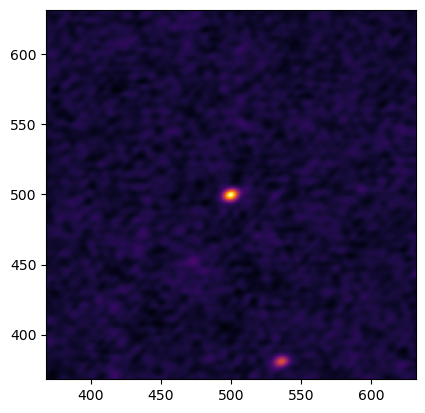

In [14]:
band = 'X'
cal = 0
filename = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'
image_data, header = load_fits_image(filename)
fig, ax = plt.subplots(1,1)
ax.imshow(image_data, cmap='inferno', origin='lower')
fwhm_deg = calculate_fwhm(8.4e9)
pixel_scale_deg = np.abs(header['CDELT1'])
pixel_scale = pixel_scale_deg

fwhm_pixels = fwhm_deg / pixel_scale

# Center the FWHM box on the image
img_center_x = image_data.shape[1] // 2
img_center_y = image_data.shape[0] // 2
half_fwhm_pixels = fwhm_pixels / 2


# Set the plot limits based on FWHM in pixels, centered on the image
ax.set_xlim(img_center_x - half_fwhm_pixels, img_center_x + half_fwhm_pixels)
ax.set_ylim(img_center_y - half_fwhm_pixels, img_center_y + half_fwhm_pixels)
plt.show()

In [51]:
img_center_x + 100

475

In [56]:
image_data.shape[1] 

450

FWHM in arcseconds: 56.25852835250671
FWHM in pixels: 203.39977578281614
FWHM in arcseconds: 56.25852835250671
FWHM in pixels: 203.39977578281614
FWHM in arcseconds: 56.25852835250671
FWHM in pixels: 203.39977578281614
FWHM in arcseconds: 56.25852835250671
FWHM in pixels: 203.39977578281614
FWHM in arcseconds: 56.25852835250671
FWHM in pixels: 203.39977578281614
FWHM in arcseconds: 75.01193875048901
FWHM in pixels: 208.73409177615673
FWHM in arcseconds: 75.01193875048901
FWHM in pixels: 208.73409177615673
FWHM in arcseconds: 75.01193875048901
FWHM in pixels: 208.73409177615673
FWHM in arcseconds: 75.01193875048901
FWHM in pixels: 208.73409177615673
FWHM in arcseconds: 75.01193875048901
FWHM in pixels: 208.73409177615673
FWHM in arcseconds: 112.51961050583441
FWHM in pixels: 219.6065588179087
FWHM in arcseconds: 112.51961050583441
FWHM in pixels: 219.6065588179087
FWHM in arcseconds: 112.51961050583441
FWHM in pixels: 219.6065588179087
FWHM in arcseconds: 112.51961050583441
FWHM in pixe

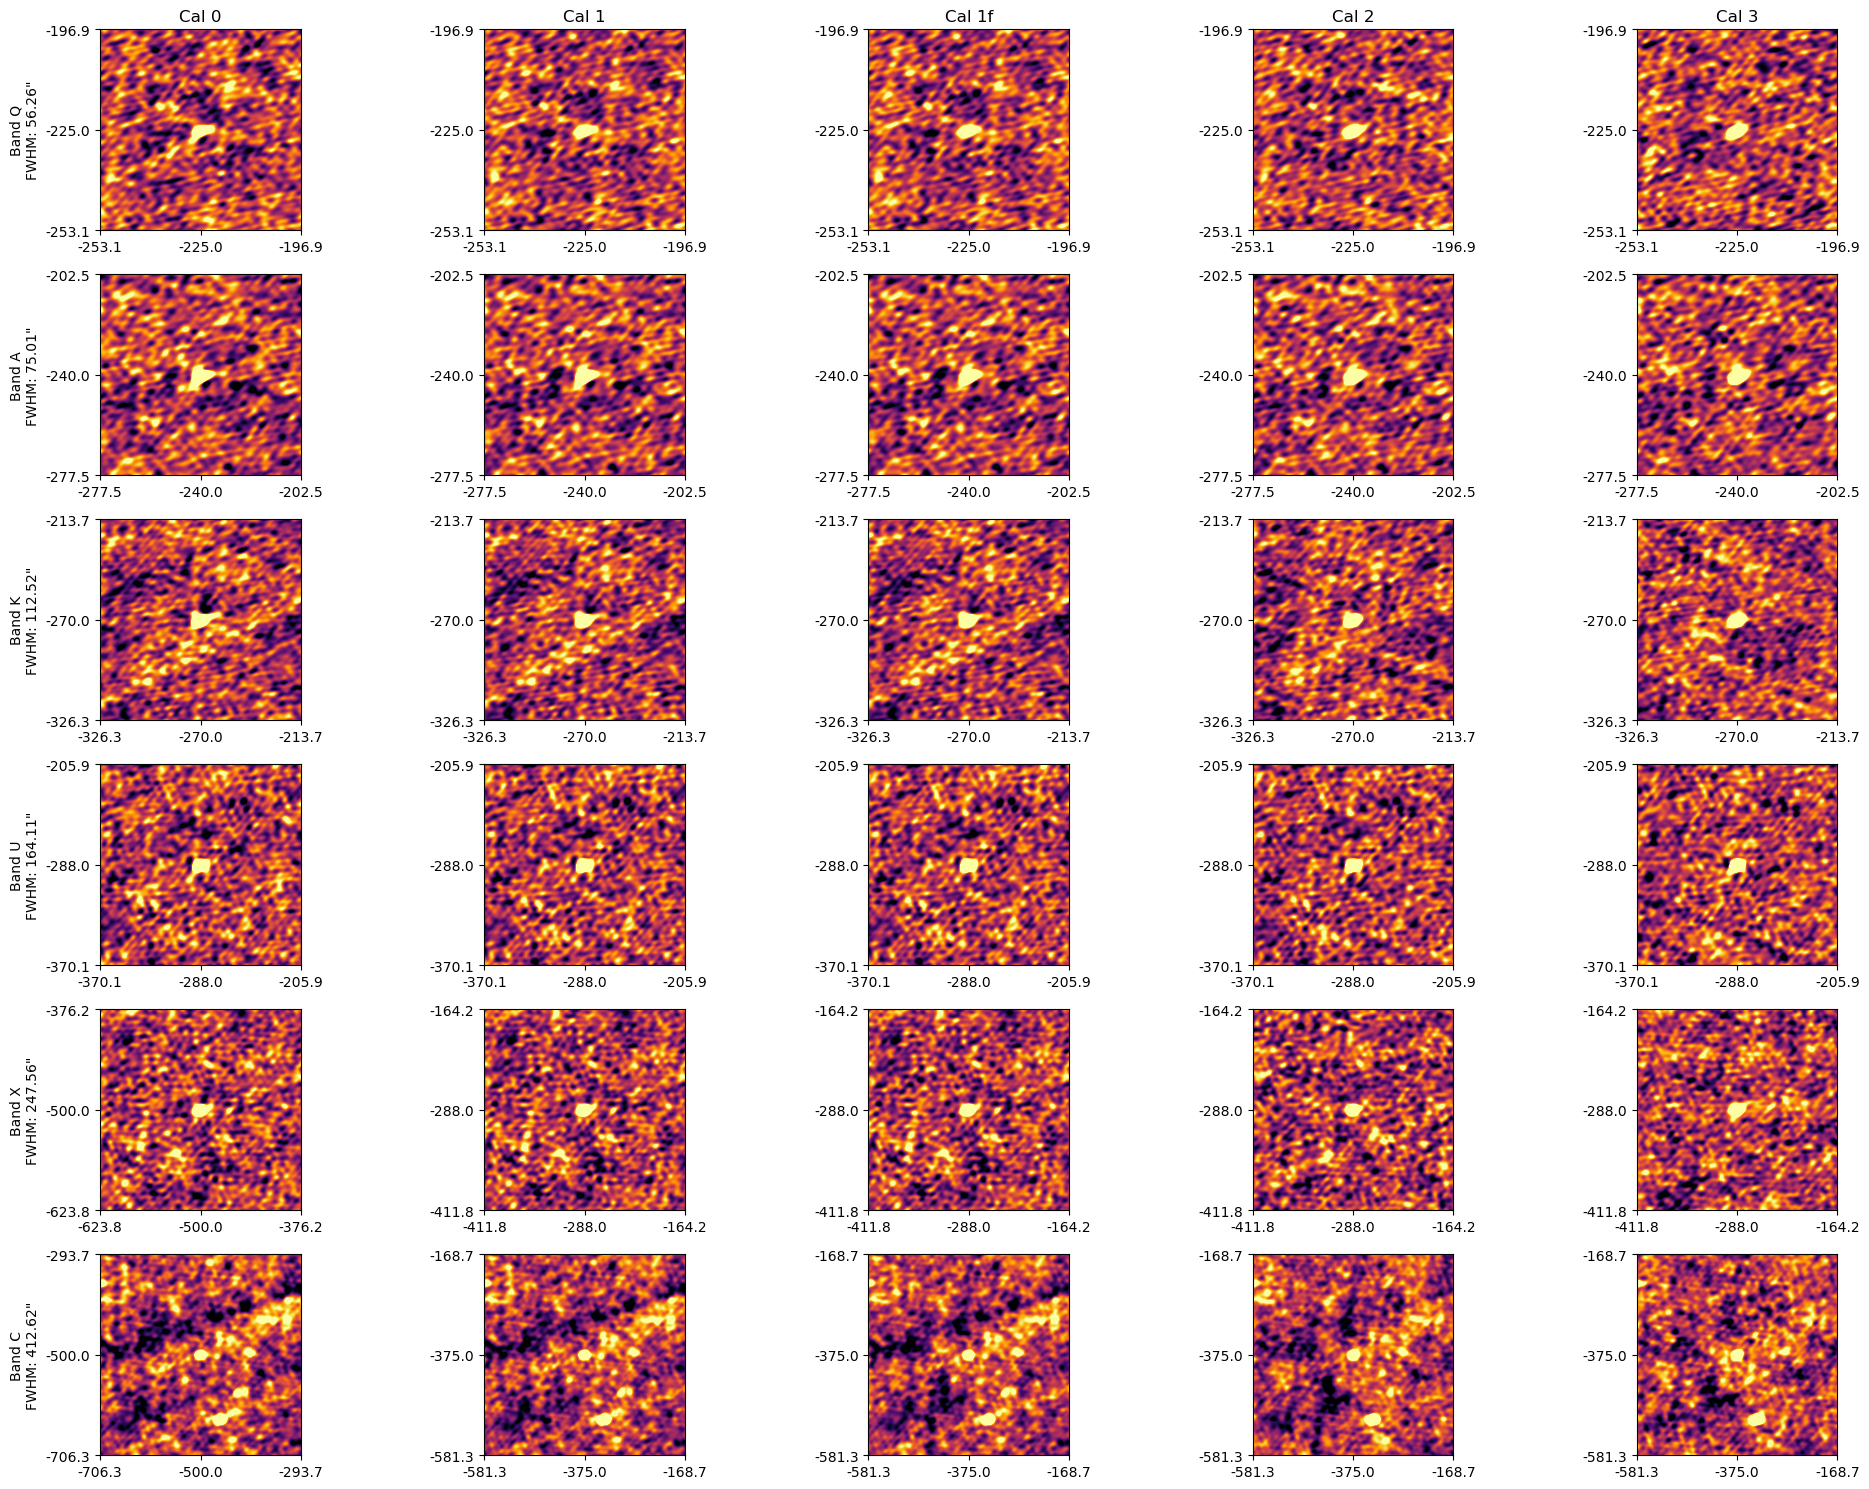

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Constants
D = 25  # VLA Antenna diameter in meters
c = 3e8  # Speed of light in m/s
arcsec_per_degree = 3600  # Conversion factor from degrees to arcseconds

# Function to calculate FWHM (lambda / D)
def calculate_fwhm(wavelength_m):
    fwhm_rad = wavelength_m / D  # FWHM in radians
    fwhm_deg = np.degrees(fwhm_rad)  # Convert to degrees
    fwhm_arcsec = fwhm_deg * arcsec_per_degree  # Convert to arcseconds
    return fwhm_arcsec

# Function to extract necessary information from FITS header and calculate FWHM in arcseconds
def calculate_fwhm_from_fits(fits_filename):
    with fits.open(fits_filename) as hdul:
        header = hdul[0].header

        # Extract the frequency (assuming it's in Hz in CRVAL3 or a similar keyword)
        frequency_hz = header.get('CRVAL3')  # Adjust the keyword if necessary

        if frequency_hz is None:
            raise ValueError("Frequency information not found in FITS header.")

        # Calculate wavelength (lambda = c / frequency)
        wavelength_m = c / frequency_hz

        # Calculate FWHM in arcseconds
        fwhm_arcsec = calculate_fwhm(wavelength_m)

        # Get the pixel scale in degrees/pixel (from CDELT1 or CDELT2) and convert to arcseconds/pixel
        pixel_scale_deg = np.abs(header['CDELT1'])  # Assuming square pixels
        pixel_scale_arcsec = pixel_scale_deg * arcsec_per_degree

        # Convert FWHM from arcseconds to pixels
        fwhm_pixels = fwhm_arcsec / pixel_scale_arcsec

        print(f"FWHM in arcseconds: {fwhm_arcsec}")
        print(f"FWHM in pixels: {fwhm_pixels}")

        return fwhm_arcsec, fwhm_pixels, pixel_scale_arcsec

# Plot the images with axes in arcseconds
def plot_images_with_arcsecond_axes(bands, calibrations, band_frequencies):
    fig, axes = plt.subplots(nrows=len(bands), ncols=len(calibrations), figsize=(20, 15))

    for i, band in enumerate(bands):
        for j, cal in enumerate(calibrations):        
            if band == 'C' or band == 'X':
                cal = cal + '-peeled'

            filename = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'

            fwhm_arcsec, fwhm_pixels, pixel_scale_arcsec = calculate_fwhm_from_fits(filename)

            # Load the FITS image data
            with fits.open(filename) as hdul:
                img = hdul[0].data.squeeze()

            # Normalize the color scale for consistent stretch across columns in a row
            vmin, vmax = np.percentile(img, [1, 99])

            # Plot the image
            ax = axes[i, j]
            ax.imshow(img, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)

            # Set title and labels for the first row/column
            if i == 0:
                ax.set_title(f'Cal {cal}')
            if j == 0:
                ax.set_ylabel(f'Band {band}\nFWHM: {fwhm_arcsec:.2f}"')

            # Calculate image center
            img_center_x = img.shape[1] // 2
            img_center_y = img.shape[0] // 2

            # Convert FWHM box size to pixels and center it
            half_fwhm_pixels = fwhm_pixels / 2

            # Set axes limits to focus on FWHM region and convert to arcseconds
            x_extent_arcsec = np.array([-half_fwhm_pixels, 0, half_fwhm_pixels]) * pixel_scale_arcsec
            y_extent_arcsec = np.array([-half_fwhm_pixels, 0, half_fwhm_pixels]) * pixel_scale_arcsec
            # Set axes limits to focus on FWHM region and convert to Δ" (delta arcseconds)
            delta_extent_arcsec = np.array([-half_fwhm_pixels, 0, half_fwhm_pixels]) * pixel_scale_arcsec

            ax.set_xlim(img_center_x - half_fwhm_pixels, img_center_x + half_fwhm_pixels)
            ax.set_ylim(img_center_y - half_fwhm_pixels, img_center_y + half_fwhm_pixels)

            # Set axis labels in Δ" (arcseconds from center)
            ax.set_xticks([img_center_x - half_fwhm_pixels, img_center_x, img_center_x + half_fwhm_pixels])
            ax.set_xticklabels([f'{x - img_center_x:.1f}' for x in delta_extent_arcsec])  # Δ" from center
            ax.set_yticks([img_center_y - half_fwhm_pixels, img_center_y, img_center_y + half_fwhm_pixels])
            ax.set_yticklabels([f'{y - img_center_y:.1f}' for y in delta_extent_arcsec])  # Δ" from center
        
    plt.tight_layout()
    plt.show()

# Example usage
bands = ["Q", "A", "K", "U", "X", "C"]
calibrations = ["0", "1", "1f", "2", "3"]
band_frequencies = {
    "Q": 45e9,
    "A": 43e9,
    "K": 24e9,
    "U": 15e9,
    "X": 8.4e9,
    "C": 5e9,
}

plot_images_with_arcsecond_axes(bands, calibrations, band_frequencies)
